The problem is an example of a multi-label image classification task, where one or more class labels must be predicted for each label. This is different from multi-class classification, where each image is assigned one from among many classes.


First we need to download the dataset from kaggle so we will only download the required data. Because this data file is so big.

In [0]:
# modify according to kaggle username and key 

!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"amitkagglepractice","key":"fbb6aeed8826cde8a23312712a265de1"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!mkdir -p data


train_v2.csv contains the labels(targets) for training.

In [0]:
# train_v2.csv 

# downloading from kaggle 
% cd /content
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p data
# unzipping
% cd /content/data
!unzip train_v2.csv.zip -d /content/data

/content
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 49.6MB/s]
/content/data
Archive:  train_v2.csv.zip
  inflating: /content/data/train_v2.csv  
   creating: /content/data/__MACOSX/
  inflating: /content/data/__MACOSX/._train_v2.csv  


train-jpg contains the images for training

In [0]:
# train-jpg.tar.7z
# this should take a little time - loading all the images 

# downloading from kaggle 
% cd /content
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p data
# unzipping 
% cd /content/data
!7z x -so train-jpg.tar.7z | tar xf - -C /content/data

/content
 99% 594M/600M [00:07<00:00, 87.2MB/s]
100% 600M/600M [00:07<00:00, 85.3MB/s]
/content/data


Till this point our data for training has been downloaded. Now we will proceed further.

### Reading the data


In [0]:

import pandas as pd

train_label = pd.read_csv('/content/data/train_v2.csv')
train_label.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


For seeing some of the images in the training dataset.

We can do this by loading some images and plotting multiple images in one figure using Matplotlib.

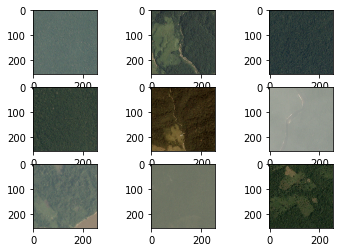

In [0]:
# plot the first 9 images in the planet dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = '/content/data/train-jpg/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'train_' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

The next step involves understanding the labels that may be assigned to each image.

In [0]:
mapping_csv = train_label
# summarize properties
print(mapping_csv.shape)
print(mapping_csv[:10])

(40479, 2)
  image_name                                         tags
0    train_0                                 haze primary
1    train_1              agriculture clear primary water
2    train_2                                clear primary
3    train_3                                clear primary
4    train_4    agriculture clear habitation primary road
5    train_5                           haze primary water
6    train_6  agriculture clear cultivation primary water
7    train_7                                 haze primary
8    train_8        agriculture clear cultivation primary
9    train_9   agriculture clear cultivation primary road


We will need the set of all known tags to be assigned to images, as well as a unique and consistent integer to apply to each tag. This is so that we can develop a target vector for each image with a one hot encoding, e.g. a vector with all zeros and a one at the index for each tag applied to the image.

In [0]:
# create a set of labels
labels = set()
for i in range(len(mapping_csv)):
	# convert spaced separated tags into an array of tags
	tags = mapping_csv['tags'][i].split(' ')
	# add tags to the set of known labels
	labels.update(tags)

In [0]:
# convert set of labels to a list to list
labels = list(labels)
# order set alphabetically
labels.sort()

We can create a dictionary that maps tags to integers so that we can encode the training dataset for modeling.

We can also create a dictionary with the reverse mapping from integers to string tag values, so later when the model makes a prediction, we can turn it into something readable.

In [0]:
# dict that maps labels to integers, and the reverse
labels_map = {labels[i]:i for i in range(len(labels))}
inv_labels_map = {i:labels[i] for i in range(len(labels))}

We can tie all of this together into a convenience function called create_tag_mapping() that will take the loaded DataFrame containing the train_v2.csv data and return a mapping and inverse mapping dictionaries.

In [0]:
# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		# convert spaced separated tags into an array of tags
		tags = mapping_csv['tags'][i].split(' ')
		# add tags to the set of known labels
		labels.update(tags)
	# convert set of labels to a list to list
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

In [0]:
mapping, inv_mapping = create_tag_mapping(mapping_csv)
print(len(mapping))
print(mapping)

17
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


We also need a mapping of training set filenames to the tags for the image.

This is a simple dictionary with the filename of the image as the key and the list of tags as the value.

In [0]:
# create a mapping of filename to tags
def create_file_mapping(mapping_csv):
	mapping = dict()
	for i in range(len(mapping_csv)):
		name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
		mapping[name] = tags.split(' ')
	return mapping

One hot encoding will be used for representing target/labels for the training purpose

In [0]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
	# create empty vector
	encoding = zeros(len(mapping), dtype='uint8')
	# mark 1 for each tag in the vector
	for tag in tags:
		encoding[mapping[tag]] = 1
	return encoding

## Loading And saving data for training

In [0]:
# load and prepare planet dataset and save to file
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [0]:
# load all images into memory
def load_dataset(path, file_mapping, tag_mapping):
	photos, targets = list(), list()
	# enumerate files in the directory
	for filename in listdir(folder):
		# load image
		photo = load_img(path + filename, target_size=(128,128))
		# convert to numpy array
		photo = img_to_array(photo, dtype='uint8')
		# get tags
		tags = file_mapping[filename[:-4]]
		# one hot encode tags
		target = one_hot_encode(tags, tag_mapping)
		# store
		photos.append(photo)
		targets.append(target)
	X = asarray(photos, dtype='uint8')
	y = asarray(targets, dtype='uint8')
	return X, y

In [0]:
# load the mapping file
filename = '/content/data/train_v2.csv'
mapping_csv = read_csv(filename)
# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(mapping_csv)
# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(mapping_csv)
# load the jpeg images
folder = '/content/data/train-jpg/'

In [0]:
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)

(40479, 128, 128, 3) (40479, 17)


In [0]:
# save both arrays to one file in compressed format
savez_compressed('planet_data.npz', X, y)

The dataset can be loaded easily later using the load() NumPy function, as follows:

In [0]:
# load prepared planet dataset
from numpy import load
data = load('planet_data.npz')
X, y = data['arr_0'], data['arr_1']
print('Loaded: ', X.shape, y.shape)

Loaded:  (40479, 128, 128, 3) (40479, 17)


### Model Evaluation Measure

Before we start modeling, we must select a performance metric.

Classification accuracy is often appropriate for binary classification tasks with a balanced number of examples in each class.

precision = true positives / (true positives + false positives)
recall = true positives / (true positives + false negatives)

F1 = 2 x (precision x recall) / (precision + recall)

F-Beta = (1 + Beta^2) x (precision x recall) / (Beta^2 x precision + recall)

The idea of a positive and negative class only makes sense for a binary classification problem. As we are predicting multiple classes, the idea of positive and negative and related terms are calculated for each class in a one vs. rest manner, then averaged across each class.

The scikit-learn library provides an implementation of F-beta via the fbeta_score() function. We can call this function to evaluate a set of predictions and specify a beta value of 2 and the “average” argument set to “samples“.

	
score = fbeta_score(y_true, y_pred, 2, average='samples')

The load_dataset() function below implements this by loading the saved dataset, splitting it into train and test components, and returning them ready for use.

In [0]:
# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY 

We can then make a prediction of all classes or all 1 values in the one hot encoded vectors.

In [0]:
# test f-beta score
from numpy import load
from numpy import ones
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

In [0]:
# load dataset
trainX, trainY, testX, testY = load_dataset()

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


In [0]:
# make all one predictions
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])

The predictions can then be evaluated using the scikit-learn fbeta_score() function with the true values in the train and test dataset.

In [0]:
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

All Ones: train=0.484, test=0.482


We will require a version of the F-beta score calculation in Keras to use as a metric.

Keras used to support this metric for binary classification problems (2 classes) prior to version 2.0 of the library; we can see the code for this older version here: metrics.py. This code can be used as the basis for defining a new metric function that can be used with Keras. A version of this function is also proposed in a Kaggle kernel titled “F-beta score for Keras“.

In [0]:
from keras import backend

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

In [0]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# make all one predictions
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions with sklearn
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones (sklearn): train=%.3f, test=%.3f' % (train_score, test_score))
# evaluate predictions with keras
train_score = fbeta(backend.variable(trainY), backend.variable(train_yhat)).eval(session=backend.get_session())
test_score = fbeta(backend.variable(testY), backend.variable(test_yhat)).eval(session=backend.get_session())
print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


W0724 11:47:10.630721 140567578519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0724 11:47:10.632356 140567578519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0724 11:47:10.633492 140567578519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



All Ones (sklearn): train=0.484, test=0.482


W0724 11:47:11.938853 140567578519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0724 11:47:11.940416 140567578519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



All Ones (keras): train=0.484, test=0.482


## Evaluate a baseline model

We are now ready to develop and evaluate a baseline convolutional neural network model for the prepared planet dataset.

We will design a baseline model with a VGG-type structure. That is blocks of convolutional layers with small 3×3 filters followed by a max pooling layer, with this pattern repeating with a doubling in the number of filters with each block added.

Specifically, each block will have two convolutional layers with 3×3 filters, ReLU activation and He weight initialization with same padding, ensuring the output feature maps have the same width and height. These will be followed by a max pooling layer with a 3×3 kernel. Three of these blocks will be used with 32, 64 and 128 filters respectively.

#### In this we will define the model from end to end

In [0]:
	# baseline model for the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [0]:
# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY
 

In [0]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

We will design a baseline model with a VGG-type structure. That is blocks of convolutional layers with small 3×3 filters followed by a max pooling layer, with this pattern repeating with a doubling in the number of filters with each block added.

Specifically, each block will have two convolutional layers with 3×3 filters, ReLU activation and He weight initialization with same padding, ensuring the output feature maps have the same width and height. These will be followed by a max pooling layer with a 3×3 kernel. Three of these blocks will be used with 32, 64 and 128 filters respectively.

The output of the final pooling layer will be flattened and fed to a fully connected layer for interpretation then finally to an output layer for prediction.

The model must produce a 17-element vector with a prediction between 0 and 1 for each output class.

If this were a multi-class classification problem, we would use a softmax activation function and the categorical cross entropy loss function. This would not be appropriate for multi-label classification, as we expect the model to output multiple 1 values, not a single 1 value. In this case, we will use the sigmoid activation function in the output layer and optimize the binary cross entropy loss function.

The model will be optimized with mini-batch stochastic gradient descent with a conservative learning rate of 0.01 and a momentum of 0.9, and the model will keep track of the “fbeta” metric during training.

The define_model() function below ties all of this together and parameterized the shape of the input and output, in case you want to experiment by changing these values or reuse the code on another dataset.

The function will return a model ready to be fit on the planet dataset.

In [0]:
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

The summarize_diagnostics() function will create a figure from this recorded history data with one plot showing loss and another the F-beta scores for the model at the end of each training epoch on the train dataset (blue lines) and test dataset (orange lines).

The created figure is saved to a PNG file with the same filename as the script with a “_plot.png” extension. This allows the same test harness to be used with multiple different script files for different model configurations, saving the learning curves in separate files along the way.

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()
 

We can tie this together and define a function run_test_harness() to drive the test harness, including the loading and preparation of the data as well as definition, fit, and evaluation of the model.

The pixel values will be normalized before fitting the model. We will achieve this by defining an ImageDataGenerator instance and specify the rescale argument as 1.0/255.0. This will normalize pixel values per batch to 32-bit floating point values, which might be more memory efficient than rescaling all of the pixel values at once in memory.

In [0]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


W0724 12:38:24.885244 140443709626240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 12:38:24.927424 140443709626240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 12:38:24.934407 140443709626240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 12:38:24.983507 140443709626240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0724 12:38:25.101194 140443709626240 deprecation_wrapp

> loss=0.427, fbeta=0.827


![base_line_evaluation](https://drive.google.com/uc?id=1HQbUs90n0Sgw1j79antjpcOpuLby-bNC)

A figure is also created and saved to file showing plots of the learning curves for the model on the train and test sets with regard to both loss and F-beta.

In this case, the plot of the loss learning curves suggests that the model has overfit the training dataset, perhaps around epoch 20 out of 50, although the overfitting has not seemingly negatively impacted the performance of the model on the test dataset with regard to the F-beta score.

How to Improve Model Performance

In the previous section, we defined a baseline model that can be used as the basis for improvement on the planet dataset.

The model achieved a reasonable F-beta score, although the learning curves suggested that the model had overfit the training dataset. Two common approaches to explore to address overfitting are dropout regularization and data augmentation. Both have the effect of disrupting and slowing down the learning process, specifically the rate that the model improves over training epochs.

We will explore both of these methods in this section. Given that we expect the rate of learning to be slowed, we give the model more time to learn by increasing the number of training epochs from 50 to 200.
Dropout Regularization

Dropout regularization is a computationally cheap way to regularize a deep neural network.

Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks with very different network structure and, in turn, making nodes in the network generally more robust to the inputs.

Typically, a small amount of dropout can be applied after each VGG block, with more dropout applied to the fully connected layers near the output layer of the model.

Image Data Augmentation

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

Data augmentation can also act as a regularization technique, adding noise to the training data and encouraging the model to learn the same features, invariant to their position in the input.

Small changes to the input photos of the satellite photos might be useful for this problem, such as horizontal flips, vertical flips, rotations, zooms, and perhaps more. These augmentations can be specified as arguments to the ImageDataGenerator instance, used for the training dataset. The augmentations should not be used for the test dataset, as we wish to evaluate the performance of the model on the unmodified photographs.

#### I will apply these both regularization and the Transfer learning technique in separate colab files. Because its RAM is Crashing and intterrupting training.